In [1]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(".cache/"+uri)
    except:
        pass
    with open(".cache/"+uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(".cache/"+uri):
        with open(".cache/"+uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()

In [2]:
data_all = np.load('datasets/quic-100p-150-40runs.npy', allow_pickle=True).item()
data = data_all['nofilter'] # adblock + decentraleyes
urls = [url for url in data]

# total incoming size
def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def toOldHARFormat(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
                data2[url][sample].append([t, add(out_h, out_b), add(inc_h, inc_b)])
    return data2

data_old_format = toOldHARFormat(data)
data_old_format_noprotections = toOldHARFormat(data_all['nofilter'])

In [3]:
from lib.features import *
from lib.rf import *

from evaluate_defense import *
from fbleau_utils import *
from lib.features import *

def get_estimate_stats(result):
    
    random_guess = []
    min_estimate = []
    last_estimate = []
    
    for k, v in result.items():
        random_guess.append(v['random-guessing'])
        min_estimate.append(v['min-estimate'])
        last_estimate.append(v['last-estimate'])
        
    return min_estimate, last_estimate, random_guess


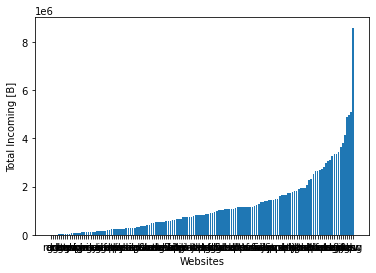

max incoming 8592264.0
max outgoing 104464.0


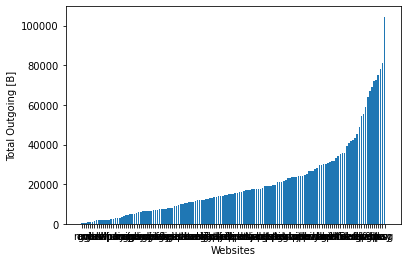

In [5]:
# total incoming size
incoming_bytes_per_website = dict()
outgoing_bytes_per_website = dict()
incoming_total_sizes = []
outgoing_total_sizes = []
max_inc=0
max_out=0

for url in data:
    outgoing_bytes_this_website = []
    incoming_bytes_this_website = []

    for sample in data[url]:
        total_inc = 0
        total_out = 0
        for request in data[url][sample]:
            domain, fullurl, t_query, out_h, out_b, t_resp, inc_h, inc_b = request
            total_inc += add(inc_h, inc_b)
            total_out += add(out_h, out_b)
        incoming_bytes_this_website.append(total_inc)
        outgoing_bytes_this_website.append(total_out)
        incoming_total_sizes.append(total_inc)
        outgoing_total_sizes.append(total_out)

    if len(incoming_bytes_this_website) > 0:
        incoming_bytes_per_website[url] =  [np.mean(incoming_bytes_this_website), np.std(incoming_bytes_this_website)]
    if len(outgoing_bytes_this_website) > 0:
        outgoing_bytes_per_website[url] =  [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
plt.show()
print(f"max incoming {max([t[1][0] for t in tuples])}")

tuples = list(outgoing_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Outgoing [B]')
print(f"max outgoing {max([t[1][0] for t in tuples])}")

In [6]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    # data is sorted, so i is never decreasing
    i = 0
    for x in data:
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    if n_cut > len(list(set(data))):
        cuts = [x for x in list(set(data))]
        cuts.sort()
        return cuts, 0, 0

    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.median(costs), np.mean(costs)

def build_padding_functions(data):
    padding_functions = []
    prev_n_cuts = -1
    for cut in range(1, 100):
        cuts, med_cost, mean_cost = find_optimal_pad(data, cut)
        if len(cuts) == prev_n_cuts:
            continue
        prev_n_cuts = len(cuts)
        padding_functions.append([cuts, med_cost, mean_cost])
    return padding_functions

incoming_total_sizes.sort()
outgoing_total_sizes.sort()

print("number of incoming sizes", len(list(set(incoming_total_sizes))))
padding_functions_inc = load_or_compute("total_pad_incoming.npy", lambda: build_padding_functions(incoming_total_sizes), rebuild=False)
padding_functions_out = load_or_compute("total_pad_outgoing.npy", lambda: build_padding_functions(outgoing_total_sizes), rebuild=False)

for cuts, med_cost, mean_cost in padding_functions_inc:
    print(len(cuts), med_cost, mean_cost)

print("number of outgoing sizes", len(list(set(outgoing_total_sizes))))
for cuts, med_cost, mean_cost in padding_functions_out:
    print(len(cuts), med_cost, mean_cost)


number of incoming sizes 4252
1 8556764.0 8244500.579006518
2 768172.0 3965156.9287480335
3 409857.0 2553271.3407507306
4 306364.0 1866825.9545965386
5 287395.0 1479649.587772533
6 194947.0 1197453.8952573612
7 170807.0 1026241.9518993032
8 153081.0 884280.5443919982
9 119591.0 783466.8264778602
10 110974.0 708487.0928298495
11 102474.0 630854.3281636323
12 87184.0 571517.0215778827
13 75831.0 513666.9840413576
14 80835.0 483193.44481906045
15 66489.0 439743.72195999103
16 67642.0 401837.04293099575
17 61850.0 382734.4198696336
18 57610.0 355906.871656552
19 54945.0 333185.7779276242
20 52994.0 313195.3528882895
21 48211.0 306589.0105641717
22 49792.0 270894.3324342549
23 49236.0 264141.63632276916
24 44715.0 249794.31332883795
25 40815.0 252803.0926050798
26 42222.0 223391.71679028997
27 40652.0 232142.4216677905
28 34602.0 224472.016183412
29 34498.0 198103.556080018
30 35791.0 186082.69094178468
31 31606.0 181601.87188132165
32 33381.0 182365.1153068105
33 28734.0 178238.257810744
3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


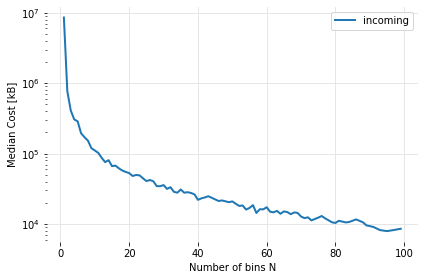

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


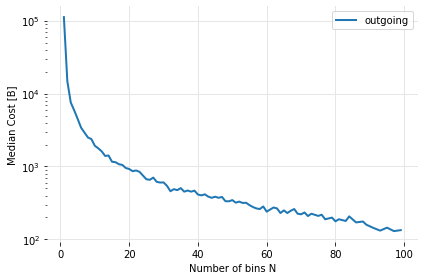

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


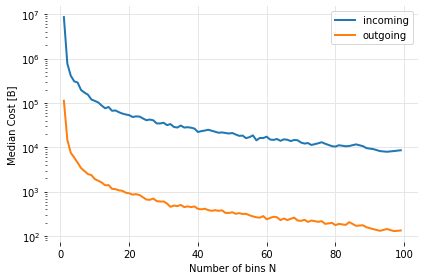

costs_inc =  [[1, 8556764.0], [2, 768172.0], [3, 409857.0], [4, 306364.0], [5, 287395.0], [6, 194947.0], [7, 170807.0], [8, 153081.0], [9, 119591.0], [10, 110974.0], [11, 102474.0], [12, 87184.0], [13, 75831.0], [14, 80835.0], [15, 66489.0], [16, 67642.0], [17, 61850.0], [18, 57610.0], [19, 54945.0], [20, 52994.0], [21, 48211.0], [22, 49792.0], [23, 49236.0], [24, 44715.0], [25, 40815.0], [26, 42222.0], [27, 40652.0], [28, 34602.0], [29, 34498.0], [30, 35791.0], [31, 31606.0], [32, 33381.0], [33, 28734.0], [34, 27914.0], [35, 30981.0], [36, 27892.0], [37, 28397.0], [38, 27656.0], [39, 26397.0], [40, 22113.0], [41, 23196.0], [42, 23896.0], [43, 24886.0], [44, 23648.0], [45, 22429.0], [46, 21299.0], [47, 21658.0], [48, 21064.0], [49, 20469.0], [50, 21000.0], [51, 19446.0], [52, 18123.0], [53, 18373.0], [54, 16077.0], [55, 16977.0], [56, 18595.0], [57, 14404.0], [58, 16251.0], [59, 16204.0], [60, 17352.0], [61, 14985.0], [62, 14701.0], [63, 15401.0], [64, 14009.0], [65, 15143.0], [66, 148

In [7]:
# plot overheads

#print("padding_function_in = ", padding_functions_inc)
#print("padding_functions_out = ", padding_functions_out)

plot_data_inc = []
plot_data_out = []
last_size = -1
i = 0
while i < len(padding_functions_inc):
    cut_inc, med_inc, _ = padding_functions_inc[i]
    plot_data_inc.append([len(cut_inc), med_inc])
    i += 1
i = 0
while i < len(padding_functions_out):
    cut_out, med_out, _ = padding_functions_out[i]
    plot_data_out.append([len(cut_out), med_out])
    i += 1

plt.plot([row[0] for row in plot_data_inc], [row[1] for row in plot_data_inc], marker="", linewidth=2, label="incoming")
plt.ylabel("Median Cost [kB]")
plt.xlabel("Number of bins N")
plt.legend()
plt.yscale('log')
plt.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../paper/plots/har-quic150-pad-total-inc.eps', format='eps',bbox_inches='tight')
plt.show()

plt.plot([row[0] for row in plot_data_out], [row[1] for row in plot_data_out], marker="", linewidth=2, label="outgoing")
plt.ylabel("Median Cost [B]")
plt.xlabel("Number of bins N")
plt.legend()
plt.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax = plt.gca()
plt.yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../paper/plots/har-quic150-pad-total-out.eps', format='eps',bbox_inches='tight')
plt.show()



plt.plot([row[0] for row in plot_data_inc], [row[1] for row in plot_data_inc], marker="", linewidth=2, label="incoming")
plt.plot([row[0] for row in plot_data_out], [row[1] for row in plot_data_out], marker="", linewidth=2, label="outgoing")
plt.ylabel("Median Cost [B]")
plt.xlabel("Number of bins N")
plt.legend()
plt.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax = plt.gca()
plt.yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../paper/plots/har-quic150-pad-total-inc-out.eps', format='eps',bbox_inches='tight')
plt.show()

print("costs_inc = ", plot_data_inc)
print("costs_out = ", plot_data_out)

In [8]:
def next_val(x, padding_function_steps):
    i = 0
    while x > padding_function_steps[i]:
        i += 1
    return padding_function_steps[i]


def pad_to_cuts(data, cut_inc, cut_out):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []

            tot_in = 0
            tot_out = 0
            for request in data[url][sample]:
                t, out, inc = request
                tot_in += inc
                tot_out += out

            pad_in = next_val(tot_in, cut_inc)
            pad_out = next_val(tot_out, cut_out)

            if len(data[url][sample]) == 0:
                data2[url][sample].append([0, pad_out, pad_in])
            else:
                pad_in_per_pkt = int(math.floor(float(pad_in-tot_in)/len(data[url][sample])))
                pad_out_per_pkt = int(math.floor(float(pad_out-tot_out)/len(data[url][sample])))

                pad_in_remain = pad_in-tot_in
                pad_out_remain = pad_out-tot_out

                for request in data[url][sample]:
                    t, out, inc = request
                    data2[url][sample].append([t, out + pad_out_per_pkt, inc + pad_in_per_pkt])
                    pad_in_remain -= pad_in_per_pkt
                    pad_out_remain -= pad_out_per_pkt

                data2[url][sample][-1][1] += pad_out_remain
                data2[url][sample][-1][2] += pad_in_remain

    return data2

def build_clf_perfs():
    clf_perfs = {}

    i = 0
    while i < len(padding_functions_out):
        cut_inc, med_inc, _ = padding_functions_inc[i]
        cut_out, med_out, _ = padding_functions_out[i]
        print(f"***************** Working on n cuts: {len(cut_inc)} {len(cut_out)}")

        data_padded = pad_to_cuts(data_old_format, cut_inc, cut_out)

        features = get_features(data_padded)
        clf_res = rf_with_rfe(features)

        clf_perfs[len(cut_inc)] = clf_res
        print(clf_res)
        i += 1
        
    return clf_perfs

clf_perfs_pad_total = load_or_compute("clf_perfs_pad_total.npy", build_clf_perfs, rebuild=False)



def build_fbleau_perfs():
    fbleau_perf = {}
    
    i = 0
    while i < len(padding_functions_out):
        cut_inc, med_inc, _ = padding_functions_inc[i]
        cut_out, med_out, _ = padding_functions_out[i]
        
        data_padded = pad_to_cuts(data_old_format, cut_inc, cut_out)
        features = get_features(data_padded)
        try:
            result = analyze_dataset(features)
            min_estimate, last_estimate, random_guess = get_estimate_stats(result)
            print("\nOverall stats:")
            print("Min estimate:", "Mean", np.mean(min_estimate), "Std", np.std(min_estimate))
            print("Last estimate:", "Mean", np.mean(last_estimate), "Std", np.std(last_estimate))
            print("Random guess estimate:", "Mean", np.mean(random_guess), "Std", np.std(random_guess))


            fbleau_perf[len(cuts)] = min_estimate
        except:
            pass

    return fbleau_perf

fbleau_perfs = load_or_compute("fbleau_perfs.npy", build_fbleau_perfs, rebuild=True)


In [9]:
for res in clf_perfs_pad_total:
    #print(res, clf_perfs_pad_total[res]['score']['f1score'])
    #plot_fi(clf_perfs_pad_total[res]['features'], title=f"{res}")
    pass

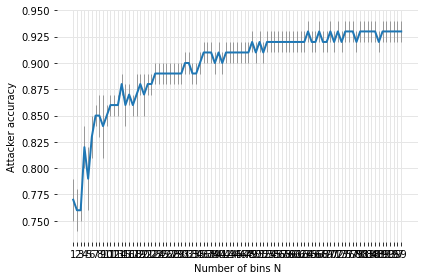

accs= [['1', 0.77, 0.02], ['2', 0.76, 0.02], ['3', 0.76, 0.01], ['4', 0.82, 0.02], ['5', 0.79, 0.03], ['6', 0.83, 0.02], ['7', 0.85, 0.01], ['8', 0.85, 0.02], ['9', 0.84, 0.03], ['10', 0.85, 0.01], ['11', 0.86, 0.01], ['12', 0.86, 0.01], ['13', 0.86, 0.01], ['14', 0.88, 0.01], ['15', 0.86, 0.02], ['16', 0.87, 0.01], ['17', 0.86, 0.01], ['18', 0.87, 0.02], ['19', 0.88, 0.01], ['20', 0.87, 0.02], ['21', 0.88, 0.01], ['22', 0.88, 0.01], ['23', 0.89, 0.01], ['24', 0.89, 0.01], ['25', 0.89, 0.01], ['26', 0.89, 0.01], ['27', 0.89, 0.01], ['28', 0.89, 0.01], ['29', 0.89, 0.01], ['30', 0.89, 0.01], ['31', 0.9, 0.01], ['32', 0.9, 0.01], ['33', 0.89, 0.01], ['34', 0.89, 0.01], ['35', 0.9, 0.01], ['36', 0.91, 0.01], ['37', 0.91, 0.01], ['38', 0.91, 0.01], ['39', 0.9, 0.01], ['40', 0.91, 0.01], ['41', 0.9, 0.01], ['42', 0.91, 0.01], ['43', 0.91, 0.01], ['44', 0.91, 0.01], ['45', 0.91, 0.01], ['46', 0.91, 0.01], ['47', 0.91, 0.01], ['48', 0.91, 0.01], ['49', 0.92, 0.01], ['50', 0.91, 0.01], ['51', 

In [12]:
to_plot = []
last_size = -1
for ncuts in clf_perfs_pad_total:

    acc = round(clf_perfs_pad_total[ncuts]['score']['accuracy'][0], 2)
    acc_std = round(clf_perfs_pad_total[ncuts]['score']['accuracy'][1], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs_pad_total[ncuts]['features'][:3]]
 
    to_plot.append([ncuts, acc, acc_std])

len_cuts = [row[0] for row in to_plot]
accs = [row[1] for row in to_plot]
accs_std = [row[2] for row in to_plot]

plt.errorbar(len_cuts, accs, yerr=accs_std, marker="", ecolor="#999", linewidth=2, elinewidth=1)
plt.ylabel("Attacker accuracy")
plt.xlabel("Number of bins N")
plt.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../paper/plots/har-quic150-pad-total-accuracy.eps', format='eps',bbox_inches='tight')
plt.show()

print("accs=", to_plot)

with open("FUCKYOU.json", "w") as f:
    json.dump(to_plot, f)


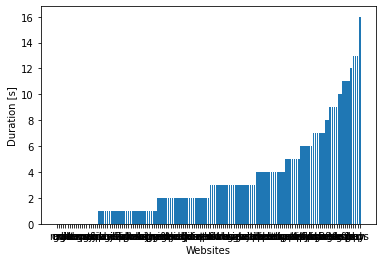

max duration 16.418


In [ ]:
# total duration size
incoming_bytes_per_website = dict()
incoming_total_sizes = []
max_inc=0
max_out=0

for url in data:
    durations = []

    for sample in data[url]:
        if len(data[url][sample]) > 0:
            durations.append(float(data[url][sample][-1][2]))

    if len(data[url][sample]) > 0:
        incoming_bytes_per_website[url] =  [np.mean(durations), np.std(durations)]

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Duration [s]')
plt.show()
print(f"max duration {max([t[1][0] for t in tuples])}")
